In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from uwv.config import KNMI_PROCESSED_DATA_DIR, KNMI_AVG_TEMP, CBS_OPENDATA_PROCESSED_DATA_DIR, CBS80072NED
import plotly.graph_objects as go

2024-11-09 15:20:18.387 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [2]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

knmi = pd.read_parquet(KNMI_PROCESSED_DATA_DIR / f"{KNMI_AVG_TEMP}.parquet")

In [3]:
# Merge the datasets on 'period_year' and 'period_quarter_number'
cbsk= pd.merge(cbs, knmi, on=['period_year', 'period_quarter_number'], how="inner")

In [4]:
# Data Preprocessing
# Filter out rows where 'period_quarter_number' is 0
cbsk = cbsk[cbsk['period_quarter_number'] != 0]

In [5]:
# Map quarters to months and create the 'date' column
cbsk['month'] = cbsk['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbsk['date'] = pd.to_datetime({'year': cbsk['period_year'], 'month': cbsk['month'], 'day': 1})

In [6]:
# Set this new 'date' column as the index
cbsk.set_index('date', inplace=True)

In [7]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbsk[cbsk['sbi'] == sbi_code]

In [8]:
# Filter the data to include only dates from 2008 to 2023
filtered_cbs = filtered_cbs.loc['2008-01-01':'2023-12-31']

In [9]:
# Set the frequency to quarterly
filtered_cbs.index.freq = 'QS'

In [10]:
# Drop any NaN values to clean the dataset
filtered_cbs = filtered_cbs.dropna()

In [11]:
# Ensure the 'sick_leave_percentage' column is in the correct format
filtered_cbs['sick_leave_percentage'] = filtered_cbs['sick_leave_percentage'].astype(float)

In [12]:
import plotly.graph_objects as go
import pandas as pd

def plot_sick_leave(filtered_cbs, title="Sick Leave Percentage"):
    fig = go.Figure()

    # Add line for sick leave percentage
    fig.add_trace(
        go.Scatter(
            x=filtered_cbs.index,
            y=filtered_cbs['sick_leave_percentage'],
            mode='lines',
            line=dict(color='#0078d2', width=1.5),
            name='Sick Leave Percentage'
        )
    )

    # Generate custom tick values and labels (show year only on Q1)
    tickvals = filtered_cbs.index
    ticktext = [f"{date.year}" if date.quarter == 1 else "" for date in filtered_cbs.index]

    # Set figure background and grid style
    fig.update_layout(
        title=title,
        plot_bgcolor='white',  # Set background color to white
        font=dict(family="Roboto", size=14),  # Set font family and size
        xaxis=dict(
            showline=True, linewidth=0.5, linecolor='black',  # Set axis line style
            showgrid=False,  # Disable vertical grid lines
            tickvals=tickvals,  # Custom tick positions
            ticktext=ticktext,  # Custom tick labels (year only on Q1)
            ticks="outside",  # Place ticks outside of the plot
            tickwidth=0.5,  # Width of tick lines
            ticklen=4,  # Length of tick marks
        ),
        yaxis=dict(
            showline=True, linewidth=0.5, linecolor='black',
            showgrid=True, gridcolor='grey', gridwidth=0.5,  # Only horizontal grid lines
            zeroline=False,
        ),
        margin=dict(l=50, r=50, t=80, b=50)  # Margins for neat layout
    )

       
    fig.show()

# Example usage with your filtered_cbs data
plot_sick_leave(filtered_cbs, title="Sick Leave Percentage Over Time: Quarterly Data for Healthcare (2008-2023)")


In [13]:
# Set Training, Testing, and Future Forecast Ranges
train = filtered_cbs.loc[:'2021-12-31']  # Train until end of 2021
test = filtered_cbs.loc['2022-01-01':'2022-12-31']  # Test on 2022
forecast_period = pd.date_range(start='2023-01-01', periods=4, freq='QS')  # Forecast for 2023

In [14]:
# Auto ARIMA Suggestion
auto_arima(train['sick_leave_percentage'], seasonal=True, m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   56
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 4)   Log Likelihood                  17.685
Date:                            Sat, 09 Nov 2024   AIC                            -29.370
Time:                                    15:20:32   BIC                            -23.574
Sample:                                01-01-2008   HQIC                           -27.155
                                     - 10-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4750      0.155     -3.057      0.002      -0.780      -0.170
ar.S.L4       -0.7218      0.145     -4.966      0.000      -1.007      -0.437
sigma2         0.0274      0.005      5.297      0.000       0.017       0.038
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.97   Prob(JB):                         0.05
Heteroskedasticity (H):               2.10   Skew:                            -0.49
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# Step 1: Create a rolling average for avg_temp
filtered_cbs['avg_temp_rolling'] = filtered_cbs['avg_temp'].rolling(window=3).mean()

# Drop rows where 'avg_temp_rolling' has NaN values to ensure clean data
filtered_cbs = filtered_cbs.dropna(subset=['avg_temp_rolling', 'sick_leave_percentage'])

# Prepare train and test sets with the rolling average as exogenous variable
train = filtered_cbs.iloc[:-8]
test = filtered_cbs.iloc[-8:]


In [16]:
def find_best_sarimax(train, p, d, q, P, D, Q, m, exog_train=None, exog_test=None):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    for order in product(p, d, q):
        for seasonal_order in product(P, D, Q):
            try:
                # SARIMAX model met hogere iteraties en powell optimalisatiemethode
                model = SARIMAX(train['sick_leave_percentage'], order=order,
                                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], m),
                                exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
                
                results = model.fit(disp=False, maxiter=1000, method='powell')

                # Controleer of de AIC lager is
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = results

            except Exception as e:
                print(f"Fout bij order {order} en seasonal_order {seasonal_order}: {e}")
                continue

    # Inspecteer optimalisatie details als er een waarschuwingsbericht is
    if best_model is not None:
        print("Optimalisatie details (mle_retvals):", best_model.mle_retvals)
        
    return best_model, best_order, best_seasonal_order, exog_test



In [17]:
# Define ranges for the parameters (initial broad search)
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
m = 4  # Start with quarterly seasonality

# Run find_best_sarimax to get baseline parameters
best_model, best_order, best_seasonal_order, exog_test = find_best_sarimax(
    train, p, d, q, P, D, Q, m,
    exog_train=train[['avg_temp_rolling']],
    exog_test=test[['avg_temp_rolling']]
)


Optimalisatie details (mle_retvals): {'fopt': -0.323816181440304, 'direc': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 'iterations': 3, 'fcalls': 137, 'warnflag': 0, 'converged': True}


In [18]:
# Narrow the grid search around initial best parameters
p = range(max(0, best_order[0] - 1), best_order[0] + 2)
d = range(0, 2)
q = range(max(0, best_order[2] - 1), best_order[2] + 2)
P = range(max(0, best_seasonal_order[0] - 1), best_seasonal_order[0] + 2)
D = range(0, 2)
Q = range(max(0, best_seasonal_order[2] - 1), best_seasonal_order[2] + 2)

# Step 3: Run the function again with refined ranges
best_model, best_order, best_seasonal_order, exog_test = find_best_sarimax(
    train, p, d, q, P, D, Q, m,
    exog_train=train[['avg_temp_rolling']],
    exog_test=test[['avg_temp_rolling']]
)

Optimalisatie details (mle_retvals): {'fopt': -0.323816181440304, 'direc': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 'iterations': 3, 'fcalls': 137, 'warnflag': 0, 'converged': True}


In [19]:
# Step 4: Make predictions using the best model with exogenous data for the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = best_model.predict(start=start, end=end, exog=exog_test[['avg_temp_rolling']]).rename('SARIMAX Predictions')

In [20]:
# Calculate MAE for all four quarters
mae_value = mean_absolute_error(test['sick_leave_percentage'], predictions)
print(f'MAE for all four quarters: {mae_value}')

# Calculate MAE for the next quarter (Q1)
mae_q1 = mean_absolute_error(test['sick_leave_percentage'].iloc[:1], predictions.iloc[:1])
print(f'MAE for the next quarter (Q1): {mae_q1}')

# Create a Plotly figure
fig = go.Figure()

# Add actual sick leave percentage line (test data)
fig.add_trace(go.Scatter(
    x=test.index,
    y=test['sick_leave_percentage'],
    mode='lines+markers',
    name='Actual',
    line=dict(color='#0078d2', width=2)
))

# Add predictions line
fig.add_trace(go.Scatter(
    x=test.index,
    y=predictions,
    mode='lines+markers',
    name='Predictions',
    line=dict(color='orange', width=2, dash='dash')
))

# Add MAE values as text annotations
fig.add_annotation(
    xref="paper", yref="paper", x=0.00, y=1.10, showarrow=False,
    text=f"MAE for all four quarters: {mae_value:.4f}",
    font=dict(size=12, color="black")
)

fig.add_annotation(
    xref="paper", yref="paper", x=0.00, y=1.15, showarrow=False,
    text=f"MAE for next quarter (Q1): {mae_q1:.4f}",
    font=dict(size=12, color="black")
)

# Customize layout
fig.update_layout(
    title='Sick Leave Percentage - Test vs Predictions Q Healtcare Branch',
    xaxis_title='Date',
    yaxis_title='Sick Leave Percentage',
    plot_bgcolor='white',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend=dict(x=0.85, y=1.15, orientation="h"),
    width=800, height=500
)

# Save the plot as a JPEG file
fig.write_image("Sick_leave_predict_sari.jpeg")

# Save the plot as an HTML file
fig.write_html("Sick_leave_predict_sari.html")

# Show plot
fig.show()


MAE for all four quarters: 0.28703087306009756
MAE for the next quarter (Q1): 0.5558436129759601


In [21]:
correlation = filtered_cbs[['sick_leave_percentage', 'avg_temp']].corr()
print("Correlation between sick_leave_percentage and avg_temp:", correlation.iloc[0, 1])


Correlation between sick_leave_percentage and avg_temp: -0.4311679236641468


In [23]:
# Train SARIMAX on the Full Dataset - Option 1
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(1, 0, 1, 4),  # Seasonal order with no differencing
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

# Outcome:Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.This warning suggests that the model does not have enough data points to reliably estimate the initial values of the seasonal AR and MA parameters. As a result, the starting parameters (coefficients) for these components are set to zero to allow the model to proceed.
# Insufficient Data: Seasonal components require enough seasonal cycles (repeated patterns) in the data to estimate the parameters effectively. If your time series is too short or lacks sufficient seasonal cycles, the model cannot accurately determine these parameters.


In [24]:
# Simplified SARIMAX model with reduced seasonal order - Option 2
#final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      #order=(1, 0, 1),  # No differencing
                      #seasonal_order=(0, 0, 0, 4),  # Simplified seasonal order
                      #enforce_stationarity=False,
                      #enforce_invertibility=False)

#final_results = final_model.fit(maxiter=1000, method='lbfgs')

In [25]:
# Adjusted SARIMAX model fitting with increased iterations and different optimization method - Option 3
final_model = SARIMAX(filtered_cbs['sick_leave_percentage'],
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 4),
                      enforce_stationarity=False,
                      enforce_invertibility=False)

final_results = final_model.fit(maxiter=2000, method='powell', tol=1e-6)

# Check the results
print(final_results.summary())

# Inspect optimization details if convergence warning persists
print(final_results.mle_retvals)


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.



Optimization terminated successfully.
         Current function value: -0.187504
         Iterations: 6
         Function evaluations: 357
                                     SARIMAX Results                                     
Dep. Variable:             sick_leave_percentage   No. Observations:                   62
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  11.625
Date:                           Sat, 09 Nov 2024   AIC                            -13.250
Time:                                   15:22:19   BIC                             -3.124
Sample:                               07-01-2008   HQIC                            -9.324
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

In [26]:
# Forecast Future Values
forecast_steps = 8  # Number of quarters to forecast
fcast = final_results.predict(len(filtered_cbs), len(filtered_cbs) + forecast_steps - 1).rename('SARIMAX Forecast')


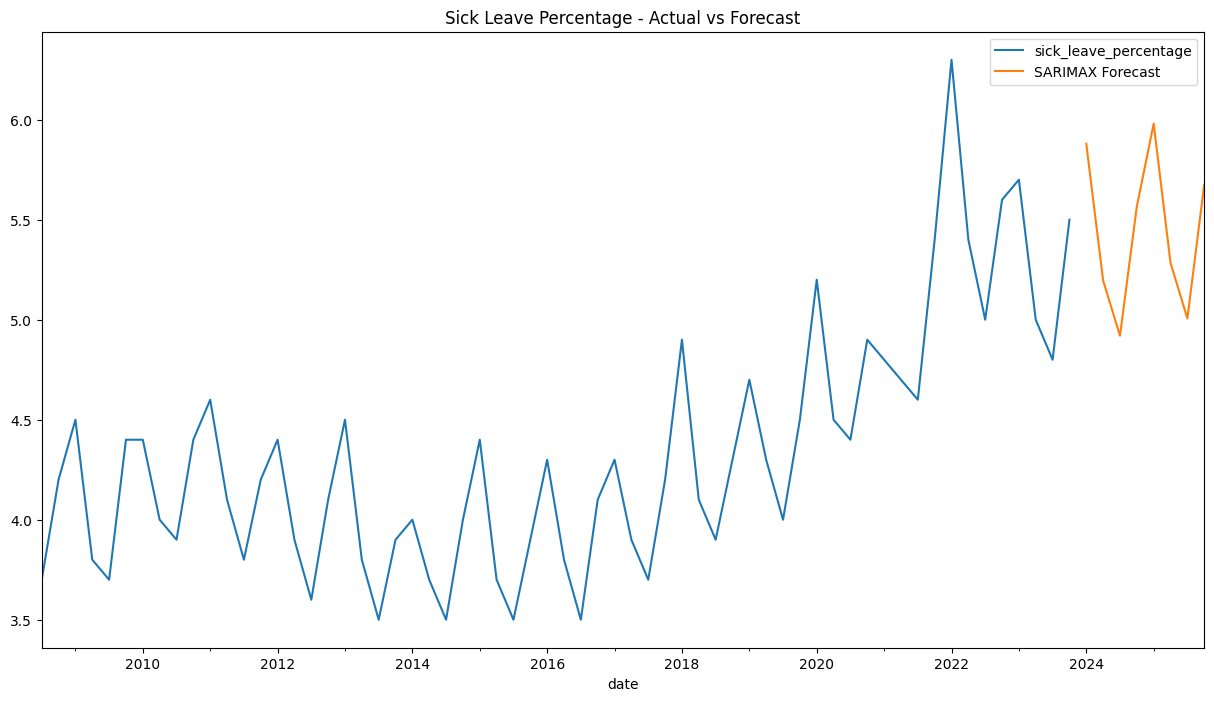

In [27]:
# Plotting the forecast
ax = filtered_cbs['sick_leave_percentage'].plot(legend=True, figsize=(15,8), title='Sick Leave Percentage - Actual vs Forecast')
fcast.plot(legend=True)

plt.show()

In [33]:
import plotly.graph_objects as go

# Ensure forecast is aligned with forecast period
forecast_period = pd.date_range(start='2023-01-01', periods=8, freq='QS')  # Adjust period as needed

# Combine test, predictions, and forecast into one plot with Plotly
fig = go.Figure()

# Add actual sick leave percentage line (test data)
fig.add_trace(go.Scatter(
    x=test.index,
    y=test['sick_leave_percentage'],
    mode='lines+markers',
    name='Actual',
    line=dict(color='#0078d2', width=2)
))

# Add predictions line for the test period
fig.add_trace(go.Scatter(
    x=test.index,
    y=predictions,
    mode='lines+markers',
    name='Predictions',
    line=dict(color='orange', width=2, dash='dash')
))

# Add forecast line for the future forecast period
fig.add_trace(go.Scatter(
    x=forecast_period,
    y=fcast,
    mode='lines+markers',
    name='Forecast',
    line=dict(color='green', width=2, dash='dot')
))

# Add MAE values as text annotations
fig.add_annotation(
    xref="paper", yref="paper", x=0.00, y=1.15, showarrow=False,
    text=f"MAE for all four quarters: {mae_value:.4f}",
    font=dict(size=12, color="black")
)

fig.add_annotation(
    xref="paper", yref="paper", x=0.00, y=1.20, showarrow=False,
    text=f"MAE for next quarter (Q1): {mae_q1:.4f}",
    font=dict(size=12, color="black")
)

# Set layout and design for better visualization
fig.update_layout(
    title='Sick Leave Percentage - Test, Predictions, and Forecast for Q Healthcare and Social Work',
    xaxis_title='Date',
    yaxis_title='Sick Leave Percentage',
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=False,
        tickformat="%Y-%m",
        range=[test.index.min(), forecast_period[-1]]  # Extend date range to the end of forecast
    ),
    yaxis=dict(
        showgrid=True, gridcolor='lightgrey', showline=True, linewidth=0.5, linecolor='black'
    ),
    legend=dict(
        x=0.91,
        y=1.5,
        traceorder="normal"
    ),
    font=dict(family="Roboto", size=14),
    margin=dict(l=50, r=50, t=80, b=50),
    width=1100, height=500
)

# Save the plot as a JPEG file
fig.write_image("Sick_leave_predict_sarimax.jpeg")

# Save the plot as an HTML file
fig.write_html("Sick_leave_predict_sarimax.html")

# Show plot
fig.show()
